<a href="https://colab.research.google.com/github/kumaran-3527/Stock-Price-Prediction/blob/main/Stock_Prediction_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Stock Prediction


The stock market is known for being volatile, dynamic, and nonlinear. Accurate stock price prediction is extremely challenging because of multiple (macro and micro) factors, such as politics, global economic conditions, unexpected events, a company’s financial performance, and so on.

Despite the volatility, stock prices aren’t just randomly generated numbers. So, they can be analyzed as a sequence of discrete-time data; in other words, time-series observations taken at successive points in time (usually on a daily basis). Time series forecasting (predicting future values based on historical values) applies well to stock forecasting.

We will be using 
    
   1.  ARIMA(Auto-Regressive Integrated Moving Average) model
   2.  LSTM model
   
to predict the stock's opening price.

#### ARIMA MODEL
A popular and widely used statistical method for time series forecasting is the ARIMA model.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a class of model that captures a suite of different standard temporal structures in time series data.

ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. It is a generalization of the simpler AutoRegressive Moving Average and adds the notion of integration.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

1. AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.

2. I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.

3. MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.





### 1. Importing required libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import mlxtend as mt

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import mean_squared_error


### 2. Data Pre-processing

In [ ]:
df = pd.read_csv("NVDA.csv").fillna(0)
df

,Date,Open,High,Low,Close,Adj Close,Volume,Company
0,07-08-2017,42.097500,43.092499,42.000000,43.087502,42.609219,71741200,NVDA
1,08-08-2017,43.472500,43.639999,42.177502,42.575001,42.102413,75533600,NVDA
2,09-08-2017,42.107498,43.052502,41.917500,43.027500,42.549892,53078400,NVDA
3,10-08-2017,43.040001,43.165001,41.082500,41.185001,40.727844,132808800,NVDA
4,11-08-2017,39.285000,39.750000,38.227501,38.990002,38.557205,149719600,NVDA
...,...,...,...,...,...,...,...,...
1253,29-07-2022,178.130005,182.440002,176.919998,181.630005,181.630005,43520200,NVDA
1254,01-08-2022,181.820007,188.460007,179.899994,184.410004,184.410004,47646900,NVDA
1255,02-08-2022,181.220001,189.380005,180.919998,185.259995,185.259995,48952700,NVDA
1256,03-08-2022,181.839996,189.679993,181.369995,188.929993,188.929993,41814600,NVDA


C:\Users\kumar\AppData\Local\Temp\ipykernel_22228\403762795.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%d-%m-%Y')


Text(0.5, 1.0, 'NVIDIA Stock Open Prices')

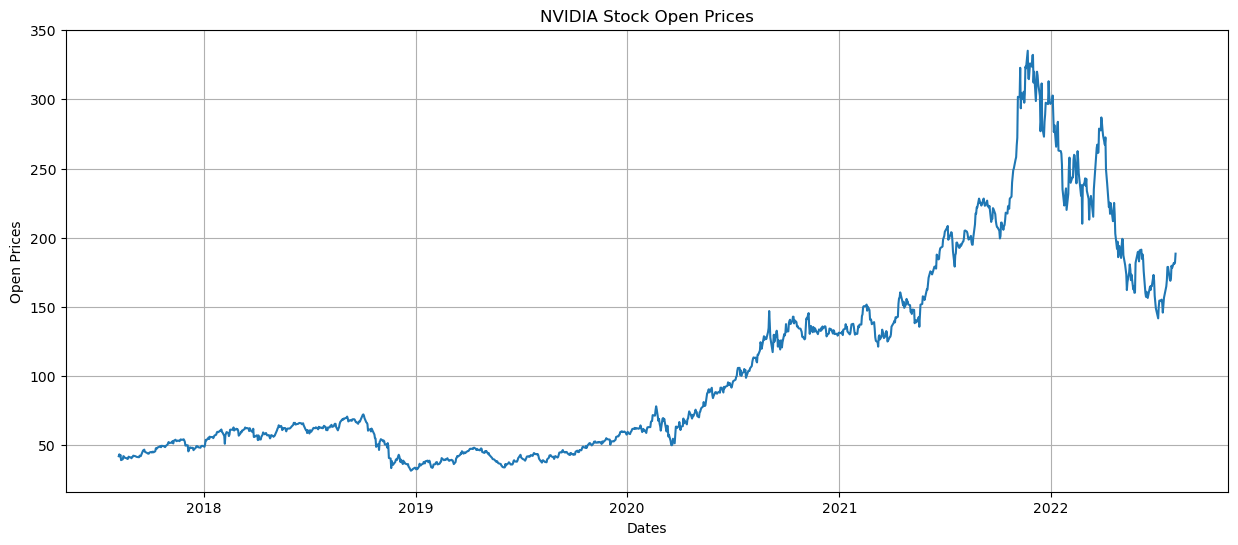

In [ ]:

## Parsing date
dateparse = lambda dates: pd.datetime.strptime(dates, '%d-%m-%Y')
data = pd.read_csv('NVDA.csv', sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)

## Plotting data 

plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'])
plt.title("NVIDIA Stock Open Prices")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


          t-1       t+1
t-1  1.000000  0.779943
t+1  0.779943  1.000000


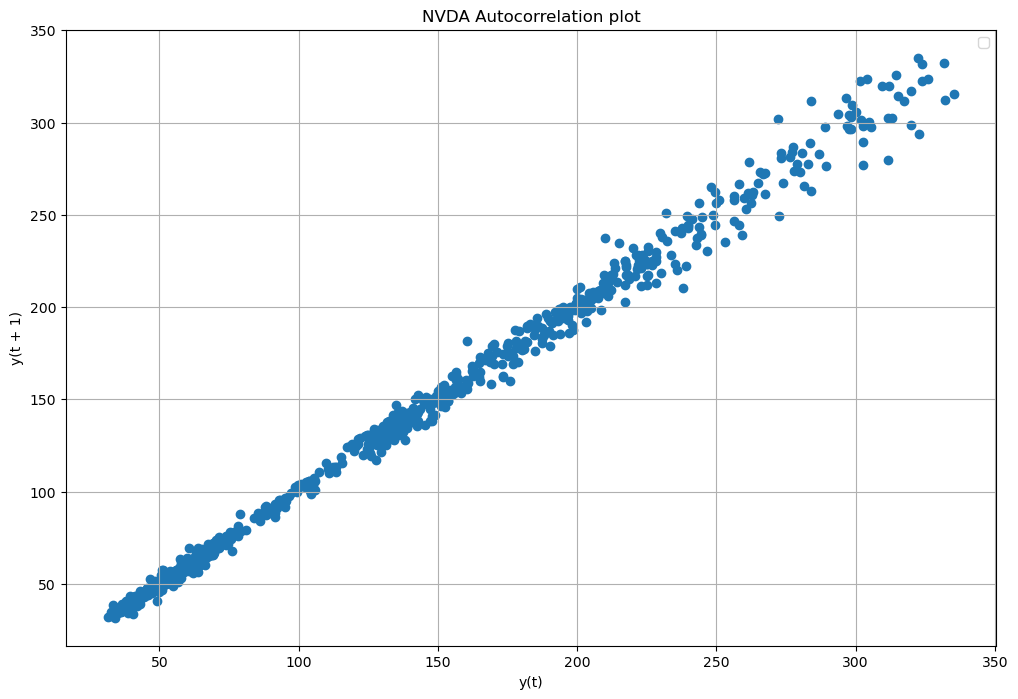

In [ ]:
from pandas.plotting import lag_plot
plt.figure(figsize=(12,8))
lag_plot(data['Open'], lag=1)
plt.title('NVDA Autocorrelation plot')
plt.grid(True)
plt.legend();

from pandas import DataFrame
from pandas import concat
values = DataFrame(data['Open'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

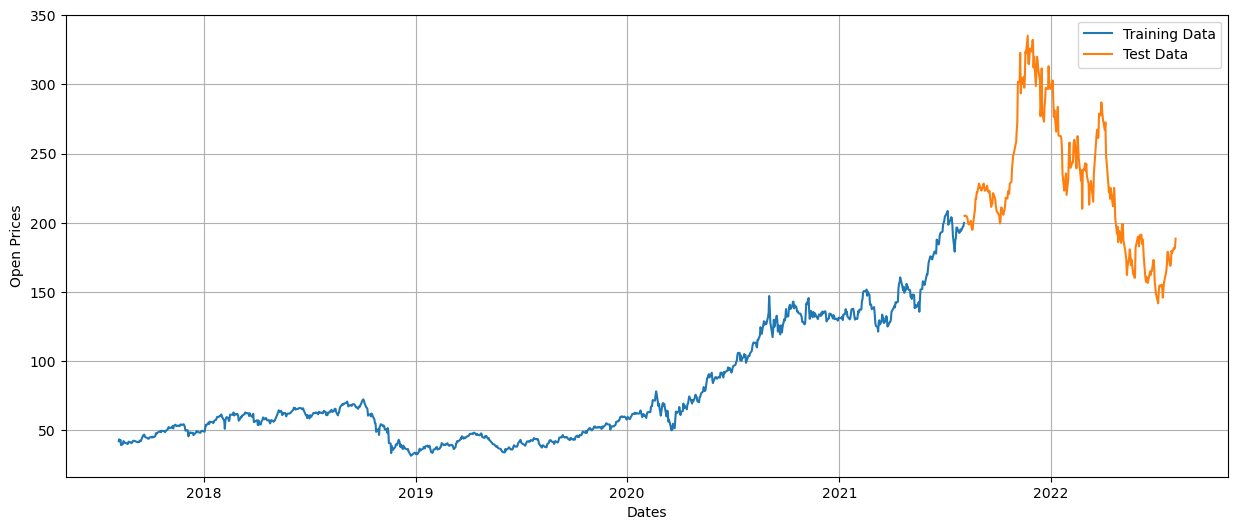

In [ ]:
## Splitting into test and training data

train , test = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):]
plt.plot(train["Open"],label='Training Data')
plt.plot(test["Open"],label="Test Data")
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.grid(True)

## 2. ARIMA Model

#### 2.1 DECOMPOSING TIME SERIES DATA INTO TREND, SEASONAL, RESIDUAL COMPONENTS

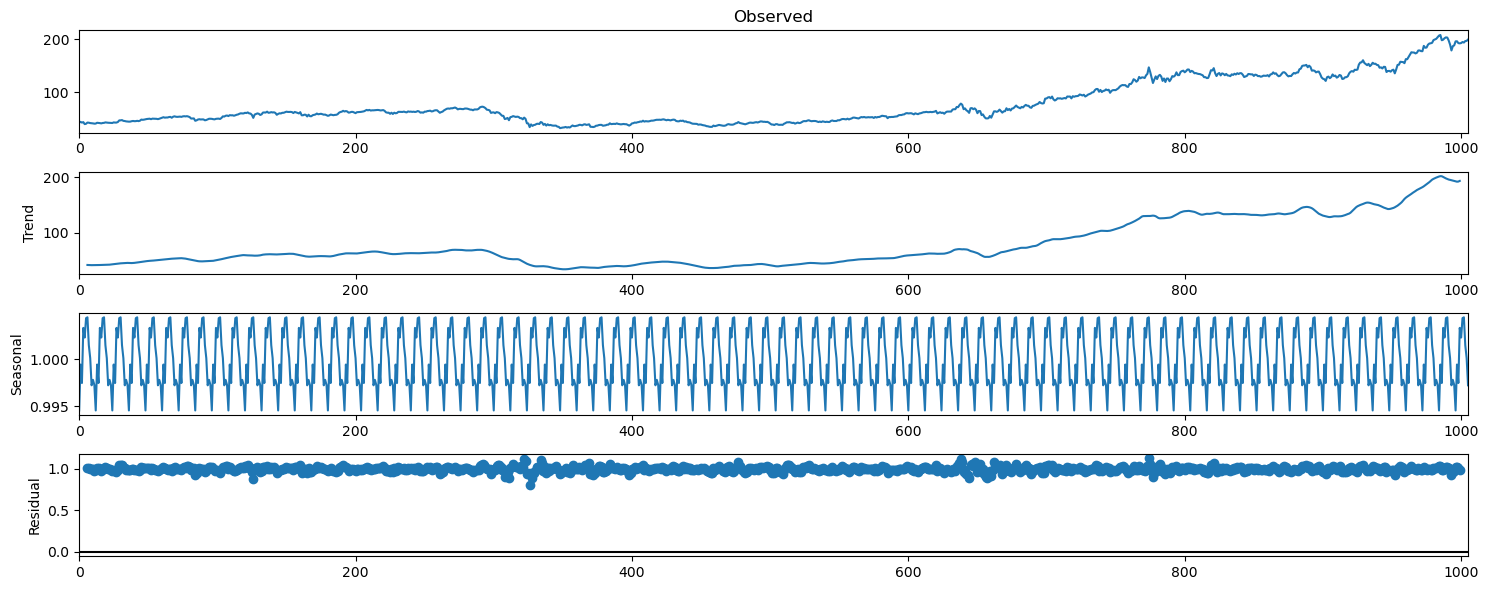

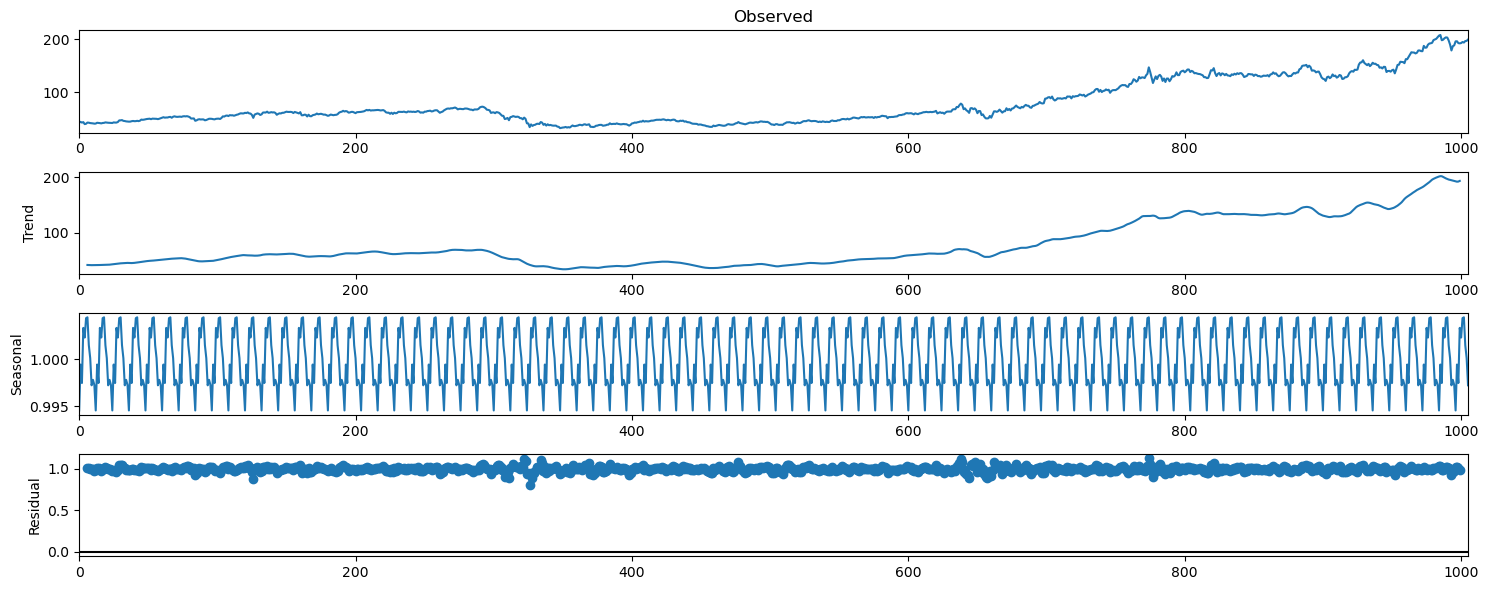

In [ ]:
train_arima = [x for x in train["Open"]]
test_arima = [x for x in test["Open"]]

train_decompose = seasonal_decompose(train_arima , model = "multiplicative" , period = 12)
train_decompose.plot()

In [ ]:
from statsmodels.tsa.stattools import adfuller

adfuller_result = adfuller(train_arima,autolag=None)
adfuller_out = pd.Series(adfuller_result[0:4],index=["Test Statistic","p_value","Lags used","No of observations used"])
print(adfuller_out)


Test Statistic               -1.844255
p_value                       0.358722
Lags used                    26.000000
No of observations used    1989.000000
dtype: float64



We see that the p-value is greater than ( p > 0.05) and hence the time series is not stationary. 
So, ARIMA model is the best bet for dealing with non-stationary time series data.

#### 2.2 MAKING THE MODEL

In [ ]:

history = train_arima
y = test_arima
y_preds = []


model = ARIMA(history, order = (1,1,1)).fit()
yhat = model.forecast()[0]
y_preds.append(yhat)
history.append(y[0])

# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    y_preds.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)


#### 2.3 Evaluating the model

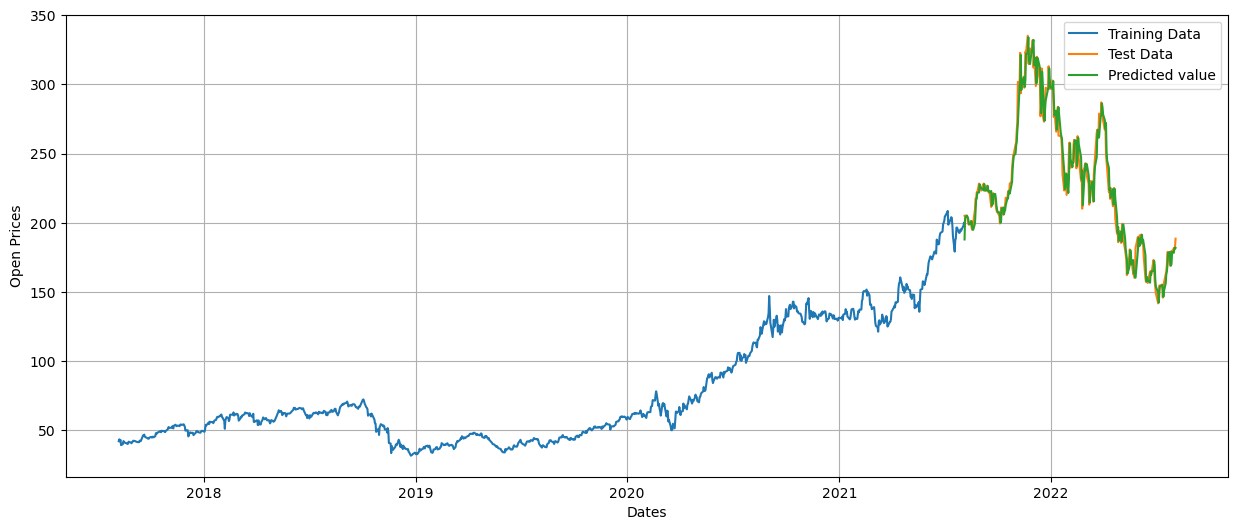

In [ ]:
plt.plot(train["Open"],label='Training Data')
plt.plot(test["Open"],label="Test Data")
plt.plot( test.index , y_preds , label = "Predicted value")
plt.legend()
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.grid(True)

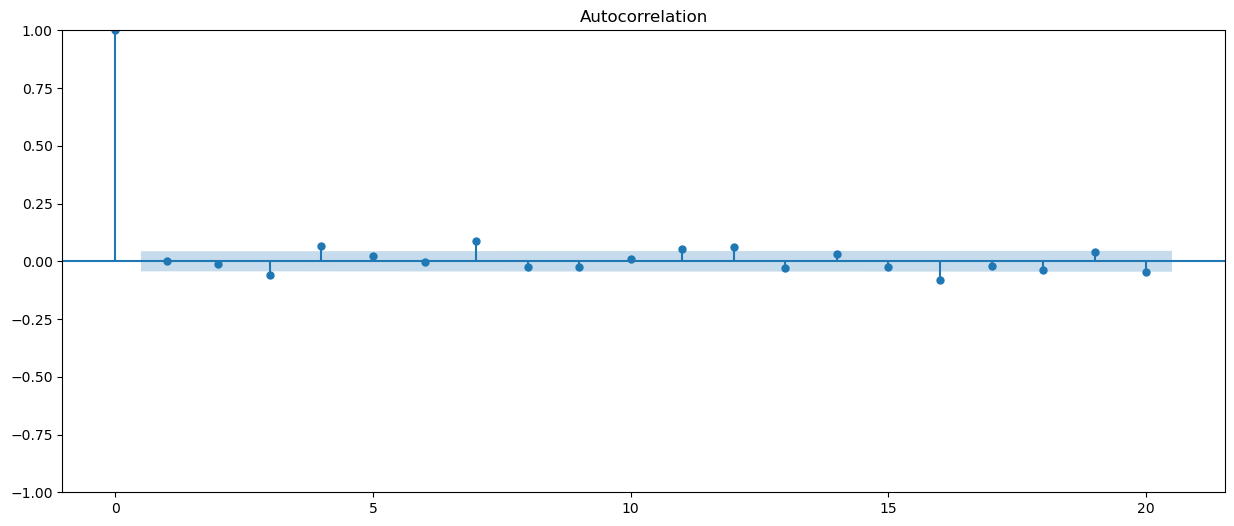

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

acf_plot = plot_acf(model_fit.resid,lags=26)

C:\Users\kumar\anaconda3\envs\ML_DL_Projects\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


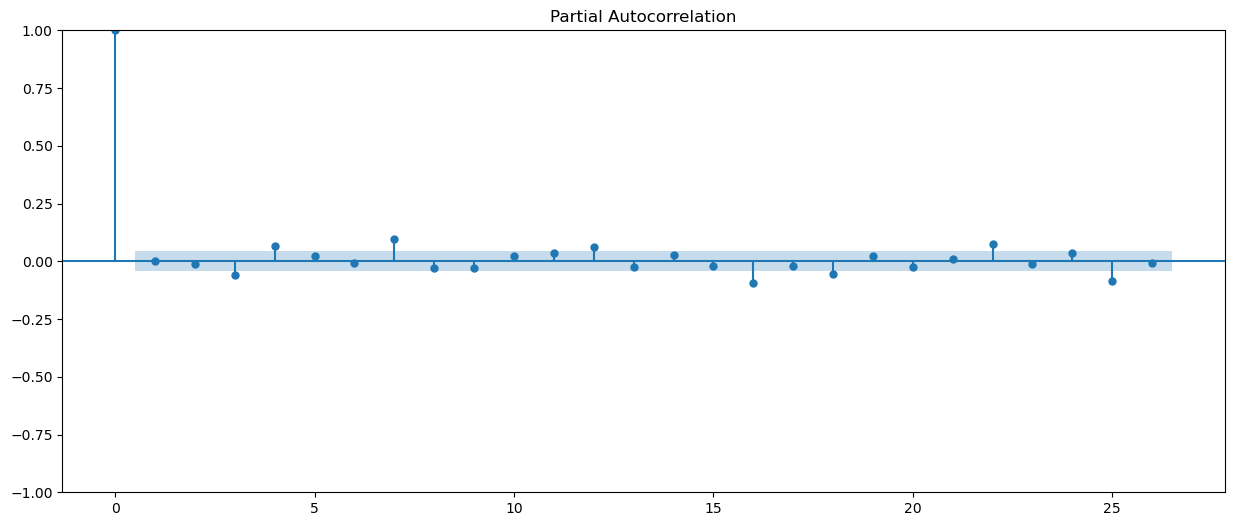

In [ ]:
pacf_plot = plot_pacf(model_fit.resid,lags=26)

In [ ]:
print("Evaluation metrics")
print("----------------------------------------------------------------------------")
import math
mse = mean_squared_error(test_arima, y_preds)
print('MSE: '+str(mse))

rmse = math.sqrt(mean_squared_error(test_arima, y_preds))
print('RMSE: '+str(rmse))

mape = mean_absolute_percentage_error(test_arima,y_preds)*100
print('MAPE: ' +str(mape))
print("----------------------------------------------------------------------------")

Evaluation metrics
----------------------------------------------------------------------------
MSE: 86.00837889545569
RMSE: 9.274070244259297
MAPE: 2.998487384029379
----------------------------------------------------------------------------
